In [1]:
# IMERG vs IFS at the same time in the ICPAC region.

import numpy as np
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from matplotlib import colors  # For consistency with Harris et. al 2022
import netCDF4 as nc
from datetime import datetime
from datetime import timedelta
from os.path import exists
import xarray as xr

In [283]:
year = 2020

IMERG_data_dir = "/home/c/cooperf/data/IMERG_6h"
# This is Andrew's quick botch on the data so don't trust it
IFS_data_dir = f"/home/c/cooperf/IFS/IFS-regICPAC-meansd/"
plot_dir = "/home/c/cooperf/IFS/junk_testing_data/pictures"
save_plots = False

# To be consistent with the Harris et. al paper.
value_range_precip = (0.1, 15)

In [138]:
# Load the constant in time latitude and longitude from a random file
# file_name = IMERG_data_dir + "/3B-HHR.MS.MRG.3IMERG.20210930-S233000-E235959.1410.V06B.HDF5.nc4"
file_name = f"{IMERG_data_dir}/20200101_00.nc4"
nc_file = nc.Dataset(file_name)
latitude = np.array(nc_file["lat"][:])  # Cropping the first point for consistency with the IFS region
longitude = np.array(nc_file["lon"][:])
nc_file.close()

In [144]:
# Load example IMERG rainfall
d = datetime(year,1,2,0)
count = 360  # There is an additional number in the file name
# file_name = f"{IMERG_data_dir}/3B-HHR.MS.MRG.3IMERG.{year}{d.month:02d}{d.day:02d}-S{d.hour:02d}{d.minute:02d}00-E{d.hour:02d}{d.minute+29:02d}59.{count:04d}.V06B.HDF5.nc4"
file_name = f"{IMERG_data_dir}/{year}{d.month:02d}{d.day:02d}_{d.hour:02d}.nc4"
nc_file = nc.Dataset(file_name)
IMERG_rain = np.array(nc_file["precipitationCal"][:,:])
nc_file.close()

In [140]:
# Load example IFS rainfall with a 24 hour lead time
file_name = f"{IFS_data_dir}/{year}/tp.nc"
nc_file = nc.Dataset(file_name)
forecast_times = np.array(nc_file["time"][:])
valid_times = np.array(nc_file["fcst_valid_time"][:])
tp = np.array(nc_file["tp_mean"][0,4,:,:])*1000/6  # Convert from m/6h to mm/h
nc_file.close()

In [141]:
# Load the cGAN forecast
file_name = f"/home/c/cooperf/data/cGAN/ICPAC/GAN_forecasts/GAN_0.nc"
nc_file = nc.Dataset(file_name)
forecast_times_GAN = np.array(nc_file["time"][:])
valid_times_GAN = np.array(nc_file["fcst_valid_time"][:])
tp_GAN = np.array(nc_file["precipitation"][0,:,0,:,:])
nc_file.close()

In [12]:
forecast_times_GAN

array([1051896.], dtype=float32)

In [13]:
forecast_times[0]

1051896.0

In [24]:
valid_times_GAN[0,0]

1051920.0

In [20]:
valid_times[0,4]

1051920.0

In [134]:
# The forecast corresponding to the GAN first valid time is [valid_times:valid_times+2]
valid_times[0,4:6]

array([1051920., 1051926.], dtype=float32)

In [137]:
# In real money this is
print(datetime(1900,1,1)+timedelta(seconds=valid_times[0,4]*3600))
print(datetime(1900,1,1)+timedelta(seconds=valid_times[0,5]*3600))

2020-01-02 00:00:00
2020-01-02 06:00:00


In [ ]:
# What is the valid time here?
# Do a quick test
# Failed to get there, but I have the correct date range.

In [165]:
IMERG_rain_orig = np.zeros((7,352,385))
for i in range(7):
    it = i
    # Load example IMERG rainfall
    d = datetime(year,1,2,it)
    count = it*60  # There is an additional number in the file name
    file_name = f"/home/c/cooperf/IFS/IMERG/3B-HHR.MS.MRG.3IMERG.{year}{d.month:02d}{d.day:02d}-S{d.hour:02d}{d.minute:02d}00-E{d.hour:02d}{d.minute+29:02d}59.{count:04d}.V06B.HDF5.nc4"
    nc_file = nc.Dataset(file_name)
    IMERG_rain_orig[i,:,:] = np.array(nc_file["precipitationCal"][:,:])
    nc_file.close()

IMERG_rain_int = (IMERG_rain_orig[0,:,1:]/2 + np.sum(IMERG_rain_orig[1:-1,:,1:], axis=0) + IMERG_rain_orig[-1,:,1:]).T/7
print(np.mean(np.abs(IMERG_rain_int - IMERG_rain)))

np.mean(np.abs(np.mean(IMERG_rain_orig[:,:,1:], axis=0).T - IMERG_rain))

0.008384423981306358


0.005910961499694118

In [161]:
IMERG_rain_int.shape

(384, 352)

In [157]:
temp[1:-1]

array([2, 3, 4, 5, 6, 7])

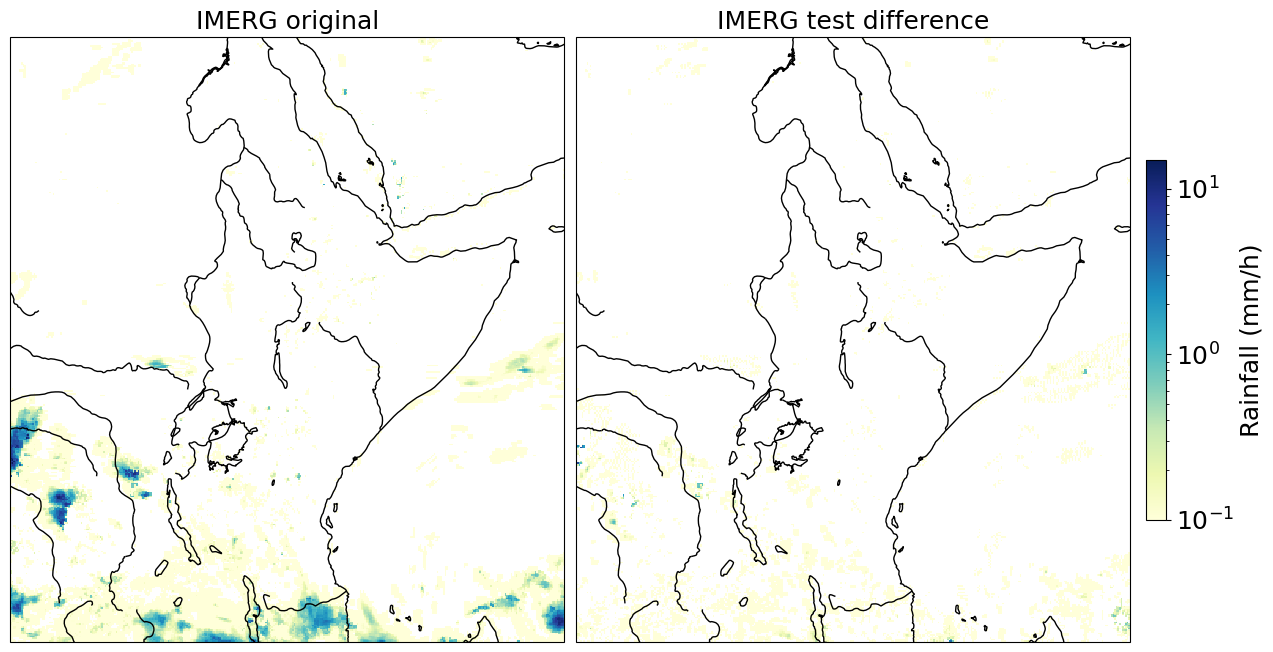

In [152]:
# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, IMERG_rain, 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IMERG original",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, np.mean(IMERG_rain_orig[:,:,1:], axis=0).T-IMERG_rain, 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title("IMERG test difference",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

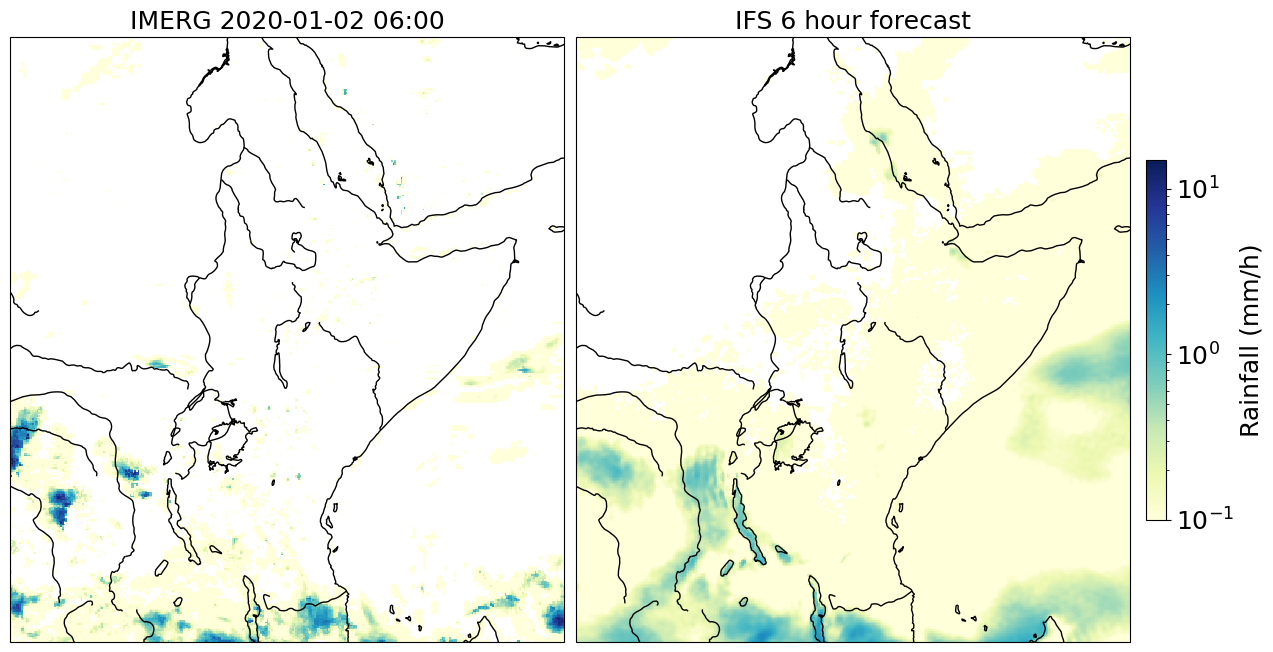

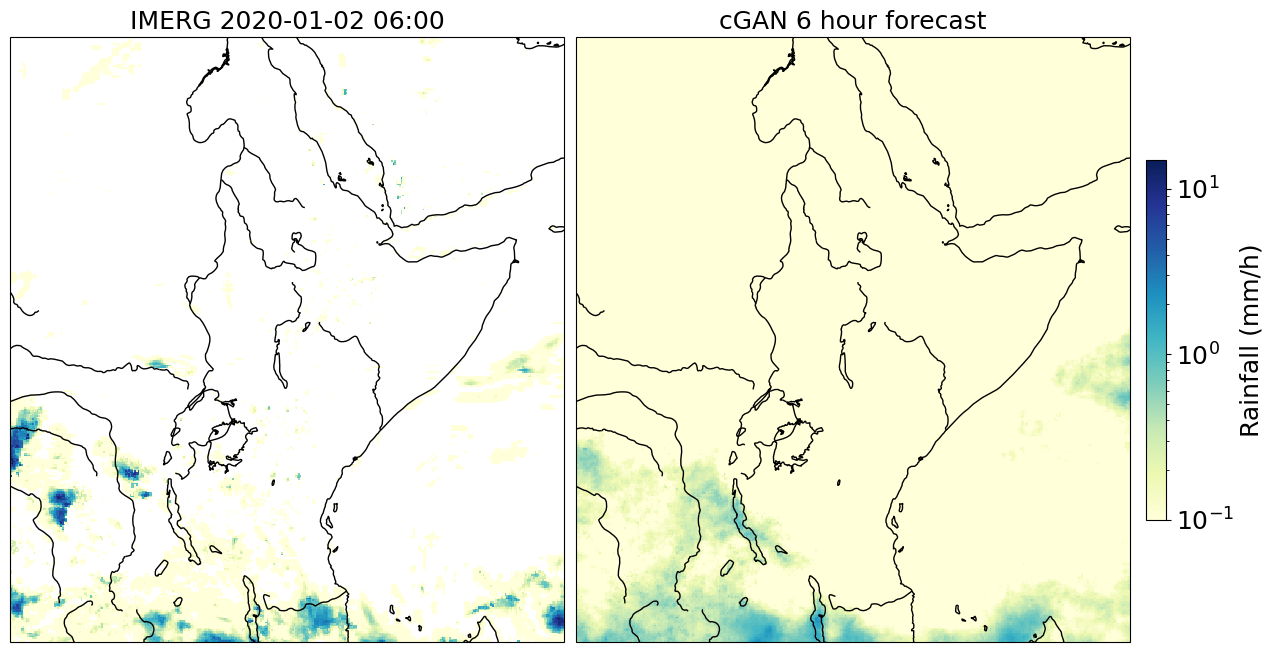

In [166]:
#
# IMERG vs IFS
#

# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, IMERG_rain, 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IMERG {d.strftime('%Y-%m-%d %H:%M')}",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, tp, 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title("IFS 6 hour forecast",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

#
# IMERG vs IFS+GAN
#

# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, IMERG_rain, 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IMERG {d.strftime('%Y-%m-%d %H:%M')}",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, np.mean(tp_GAN,axis=0), 
                  norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title("cGAN 6 hour forecast",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

In [181]:
timedelta(hours=1)

datetime.timedelta(seconds=3600)

In [355]:
# Now compare all of the GAN forecasts, IFS forecasts and IMERG data

IMERG_rain_all = np.zeros((366,4,len(latitude),len(longitude)))
tp_all = np.zeros((366,4,len(latitude),len(longitude)))
tp_GAN_mean_all = np.zeros((366,4,len(latitude),len(longitude)))

for day_num in range(366):   # 0 to 365 (366 days in 2020)
    print(day_num)
    for valid_time_num in range(4):  # There are 4 valid times in each GAN forecast

        # Load example IMERG rainfall
        d = datetime(year,1,2,6*valid_time_num) + timedelta(days=day_num)
        file_name = f"{IMERG_data_dir}/{year}{d.month:02d}{d.day:02d}_{d.hour:02d}.nc4"
        nc_file = nc.Dataset(file_name)
        IMERG_rain = np.array(nc_file["precipitationCal"][:,:])
        nc_file.close()
        
        # Load example IFS rainfall with a 24 hour lead time
        file_name = f"{IFS_data_dir}/{year}/tp.nc"
        nc_file = nc.Dataset(file_name)
        #forecast_times = np.array(nc_file["time"][:])
        #valid_times = np.array(nc_file["fcst_valid_time"][:])
        tp = np.array(nc_file["tp_mean"][day_num,4+valid_time_num,:,:])*1000/6  # Convert from m/6h to mm/h
        nc_file.close()
        
        # Load the cGAN forecast
        file_name = f"/home/c/cooperf/data/cGAN/ICPAC/GAN_forecasts/GAN_{day_num}.nc"
        nc_file = nc.Dataset(file_name)
        #forecast_times_GAN = np.array(nc_file["time"][:])
        #valid_times_GAN = np.array(nc_file["fcst_valid_time"][:])
        tp_GAN = np.array(nc_file["precipitation"][0,:,valid_time_num,:,:])
        nc_file.close()
        
        # Take the ensemble mean
        tp_GAN_mean = np.mean(tp_GAN, axis=0)
        
        # Save for later
        IMERG_rain_all[day_num,valid_time_num,:,:] = IMERG_rain
        tp_all[day_num,valid_time_num,:,:] = tp
        tp_GAN_mean_all[day_num,valid_time_num,:,:] = tp_GAN_mean

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [370]:
# Compute the RMSE
IFS_RMSE = np.sqrt(np.mean((IMERG_rain_all - tp_all)**2, axis=0))
cGAN_RMSE = np.sqrt(np.mean((IMERG_rain_all - tp_GAN_mean_all)**2, axis=0))

In [351]:
tp_all.shape

(366, 4, 384, 352)

In [352]:
IMERG_rain_all.shape

(366, 4, 384, 352)

In [353]:
tp_GAN_mean_all.shape

(366, 4, 384, 352)

In [354]:
print(np.max(tp_all[1:,:,:,:]))
print(np.max(IMERG_rain_all[1:,:,:,:]))
print(np.max(tp_GAN_mean_all[1:,:,:,:]))

2.6826093196868896
19.334993362426758
2.264460325241089


In [326]:
print(forecast_times.shape)
print(valid_times[:,4:8].shape)
print(latitude.shape)
print(longitude.shape)

(366,)
(366, 4)
(384,)
(352,)


In [356]:
# Save the data for later processing
output_data_dir = "/home/c/cooperf/IFS/To_ICPAC/Jan_2024"
file_name = "forecast_comparison.nc"

# Create a new NetCDF file
rootgrp = nc.Dataset(f"{output_data_dir}/{file_name}", "w", format="NETCDF4")

# Describe where this data comes from
rootgrp.description = "IFS, cGAN forecasts and IMERG rain data for 2020."

# Create dimensions
longitude_dim = rootgrp.createDimension("longitude", len(longitude))
latitude_dim = rootgrp.createDimension("latitude", len(latitude))
time_dim = rootgrp.createDimension("time", None)
valid_time_dim = rootgrp.createDimension("valid_time", 4)
#ensemble_dim = rootgrp.createDimension("member", num_ensemble_members)

# Create the longitude variable
longitude_data = rootgrp.createVariable("longitude", "f4", ("longitude"), zlib=False)
longitude_data.units = "degrees_east"
longitude_data[:] = longitude   # Write the longitude data

# Create the latitude variable
latitude_data = rootgrp.createVariable("latitude", "f4", ("latitude"), zlib=False)
latitude_data.units = "degrees_north"
latitude_data[:] = latitude     # Write the latitude data

# Create the time variable
time_data = rootgrp.createVariable("time", "f4", ("time"), zlib=False)
time_data.units = "hours since 1900-01-01 00:00:00.0"
time_data[:] = forecast_times     # Write the forecast_times data
    
# Create the valid_time variable
valid_time_data = rootgrp.createVariable("valid_time", "f4", ("time","valid_time"), zlib=False)
valid_time_data.units = "hours since 1900-01-01 00:00:00.0"
valid_time_data[:] = valid_times[:,4:8]     # Write the valid_times data

# Create the IMERG_rain_all variable
IMERG_data = rootgrp.createVariable("IMERG", "f4", ("time","valid_time","latitude","longitude"), zlib=True)
IMERG_data.description = "IMERG average rainfall over 6 hours starting at the valid time."
IMERG_data.units = "mm/h"
IMERG_data[:] = IMERG_rain_all     # Write the IMERG_rain_all data

# Create the IMERG_rain_all variable
IFS_data = rootgrp.createVariable("IFS", "f4", ("time","valid_time","latitude","longitude"), zlib=True)
IFS_data.description = "Ensemble mean IFS average rainfall over 6 hours starting at the valid time."
IFS_data.units = "mm/h"
IFS_data[:] = tp_all     # Write the tp_all data

# Create the IMERG_rain_all variable
cGAN_data = rootgrp.createVariable("cGAN", "f4", ("time","valid_time","latitude","longitude"), zlib=True)
cGAN_data.description = "Ensemble mean cGAN average rainfall over 6 hours starting at the valid time."
cGAN_data.units = "mm/h"
cGAN_data[:] = tp_GAN_mean_all     # Write the tp_GAN_mean_all data

# Close the NetCDF file
rootgrp.close()

In [ ]:
# Save this for processing. Then I can get the full RMSE offline.

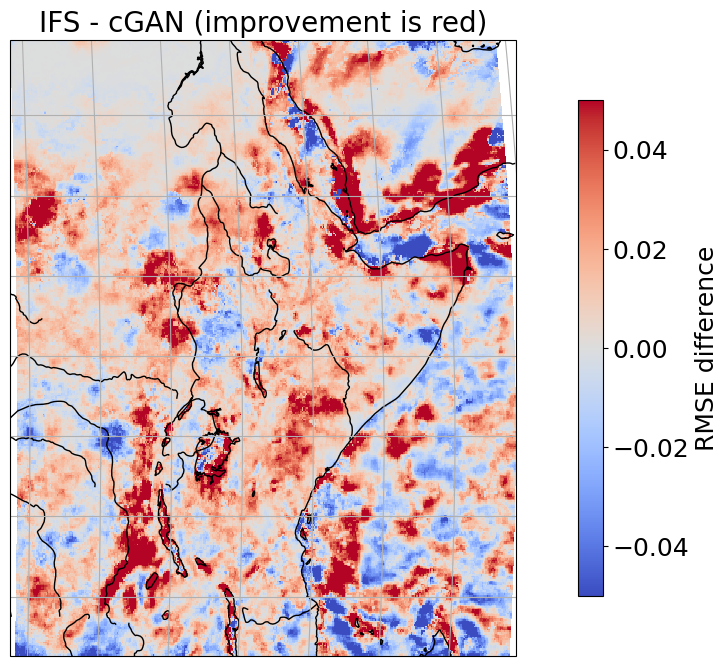

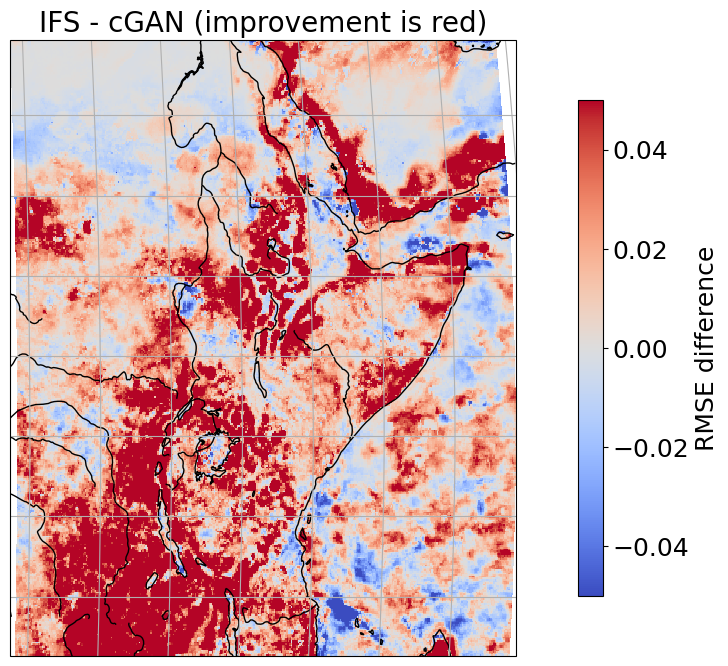

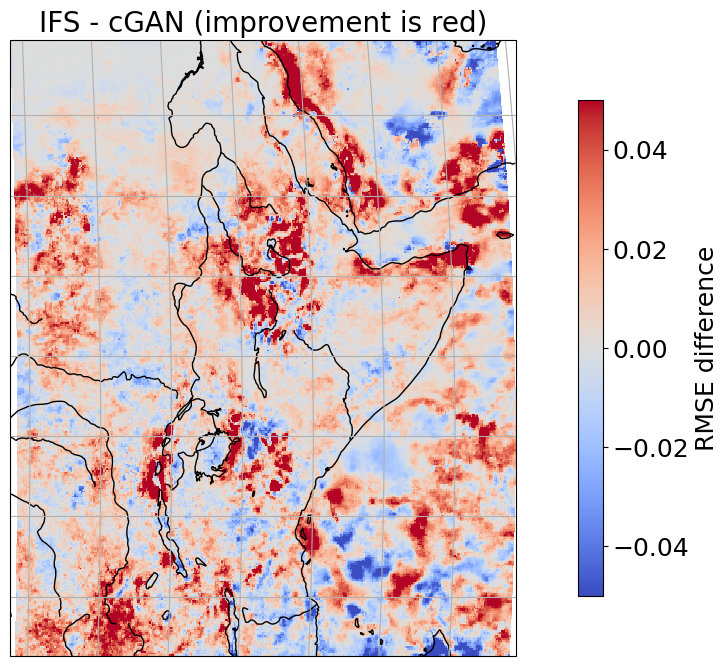

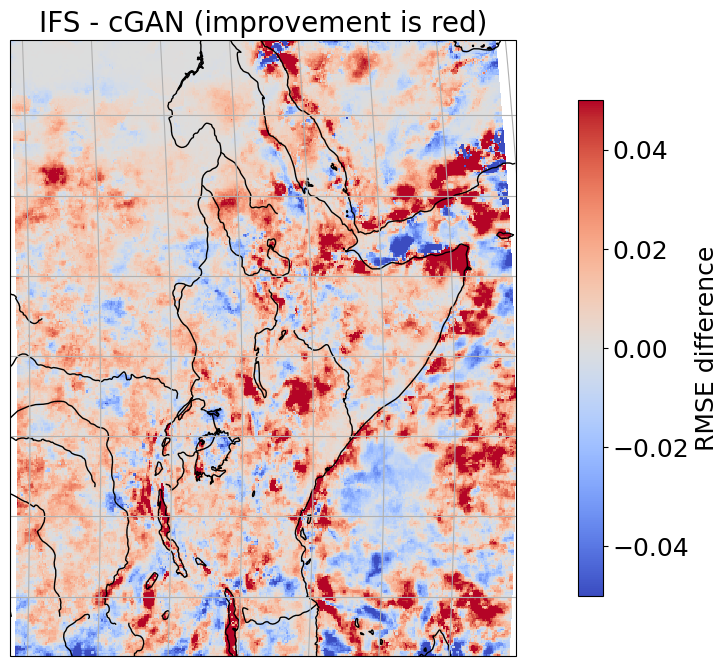

In [371]:
for valid_time_num in range(4):  # There are 4 valid times in each GAN forecast

    fig = plt.figure(figsize=(16,8))
    ax = plt.axes(projection=ccrs.Robinson())
    
    ax.gridlines()
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
    ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
    
    c = plt.pcolormesh(longitude, latitude, IFS_RMSE[valid_time_num,:,:]-cGAN_RMSE[valid_time_num,:,:],
                       #norm=colors.LogNorm(*value_range_precip),
                       vmin=-0.05, vmax=0.05,
                       transform=ccrs.PlateCarree(), cmap='coolwarm')
    
    plt.title("IFS - cGAN (improvement is red)", fontdict = {'fontsize':20})
    cb = plt.colorbar(c, fraction=0.02)
    cb.ax.tick_params(labelsize=18)
    cb.set_label('RMSE difference',size=18)
    
    # if savePlots:
    #     plt.savefig("ERA5_2mTc_2022-01-01.png", format="png", bbox_inches='tight')
    
    plt.show()

In [358]:
# Compute the 24 hour RMSE
IFS_24h_RMSE = np.sqrt(np.mean(np.sum(IMERG_rain_all - tp_all, axis=1)**2, axis=0))
cGAN_24h_RMSE = np.sqrt(np.mean(np.sum(IMERG_rain_all - tp_GAN_mean_all, axis=1)**2, axis=0))

In [359]:
save_plots = True

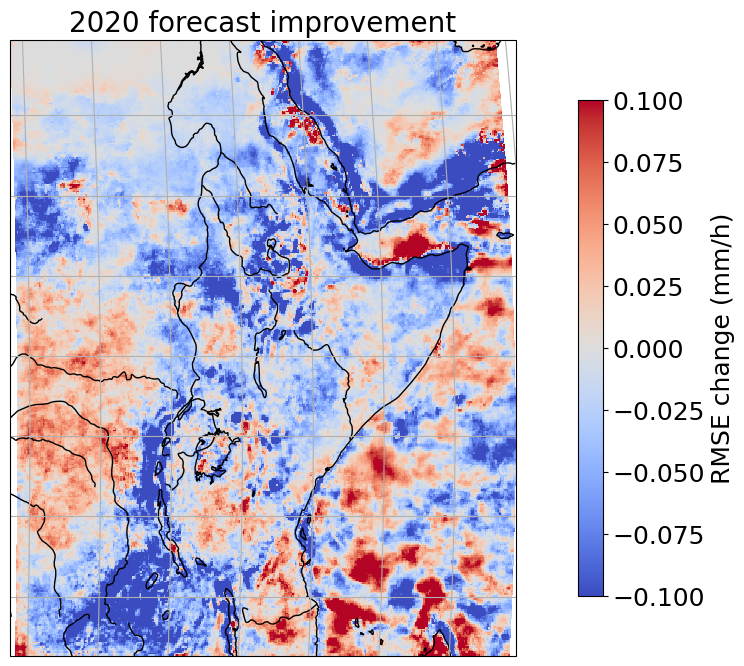

In [360]:
fig = plt.figure(figsize=(16,8))
ax = plt.axes(projection=ccrs.Robinson())

ax.gridlines()
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
#ax.add_feature(cfeature.BORDERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')

c = plt.pcolormesh(longitude, latitude, cGAN_24h_RMSE-IFS_24h_RMSE,
                   #norm=colors.LogNorm(*value_range_precip),
                   vmin=-0.1, vmax=0.1,
                   transform=ccrs.PlateCarree(), cmap='coolwarm')

plt.title("2020 forecast improvement", fontdict = {'fontsize':20})
cb = plt.colorbar(c, fraction=0.02)
cb.ax.tick_params(labelsize=18)
cb.set_label('RMSE change (mm/h)',size=18)

if save_plots:
    plt.savefig("plots/RMSE_change_2020.png", format="png", bbox_inches='tight')
    plt.savefig("plots/RMSE_change_2020_hRes.png", dpi=600, format="png", bbox_inches='tight')
    plt.savefig("plots/RMSE_change_2020.pdf", format="pdf", bbox_inches='tight')

    # plt.savefig("plots/RMSE_change_2020_borders.png", format="png", bbox_inches='tight')
    # plt.savefig("plots/RMSE_change_2020_borders_hRes.png", dpi=600, format="png", bbox_inches='tight')
    # plt.savefig("plots/RMSE_change_2020_borders.pdf", format="pdf", bbox_inches='tight')

plt.show()

In [368]:
IMERG_rain_all.shape

(366, 4, 384, 352)

In [367]:
np.mean(cGAN_24h_RMSE)

0.967111880658488

In [263]:
np.mean((IMERG_rain_all[:,:,14,193]-tp_all[:,:,14,193])**2, axis=0)

array([0.00566352, 0.0013935 , 0.00898031, 0.00511124])

In [264]:
np.mean((IMERG_rain_all[:,:,14,193]-tp_GAN_mean_all[:,:,14,193])**2, axis=0)

array([0.01222209, 0.00021843, 0.00256844, 0.0053235 ])

In [267]:
np.mean((np.sum(IMERG_rain_all[:,:,14,193],axis=1)-np.sum(tp_all[:,:,14,193],axis=1))**2, axis=0)

0.00021477451880769238

In [268]:
np.mean((np.sum(IMERG_rain_all[:,:,14,193],axis=1)-np.sum(tp_GAN_mean_all[:,:,14,193],axis=1))**2, axis=0)

0.013937363792756514

In [ ]:
# Compute the 24 hour RMSE
IFS_24h_RMSE = np.sqrt(np.mean(np.sum(IMERG_rain_all - tp_all, axis=1)**2, axis=0))
cGAN_24h_RMSE = np.sqrt(np.mean(np.sum(IMERG_rain_all - tp_GAN_mean_all, axis=1)**2, axis=0))

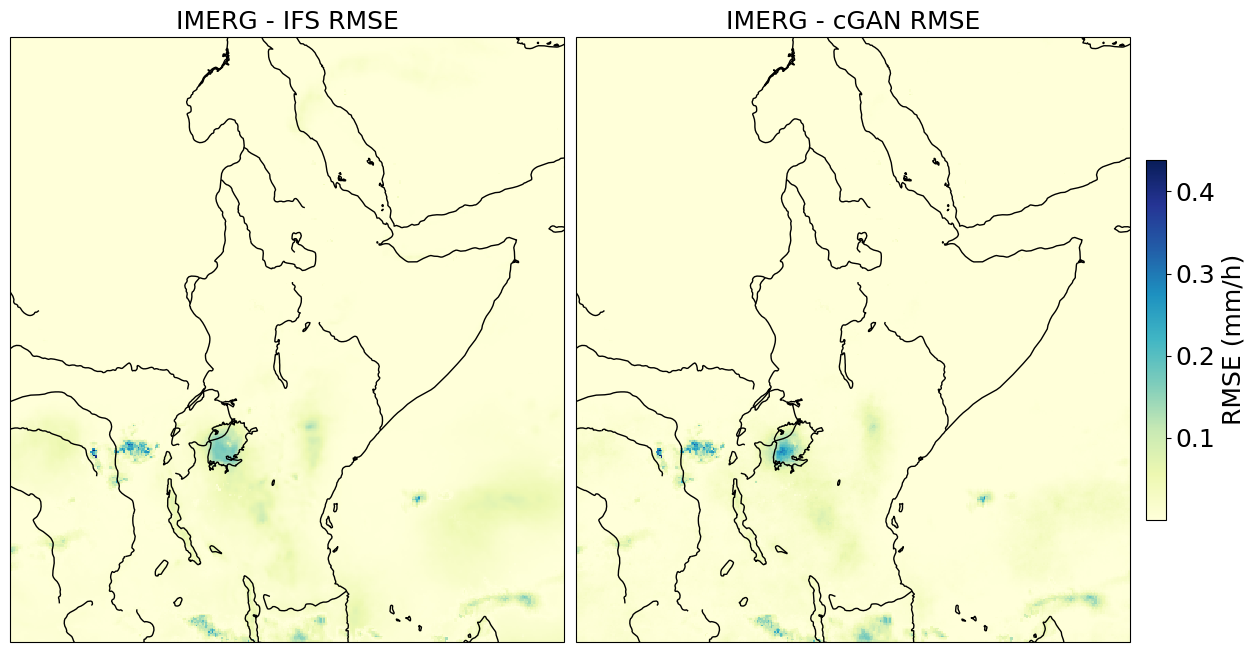

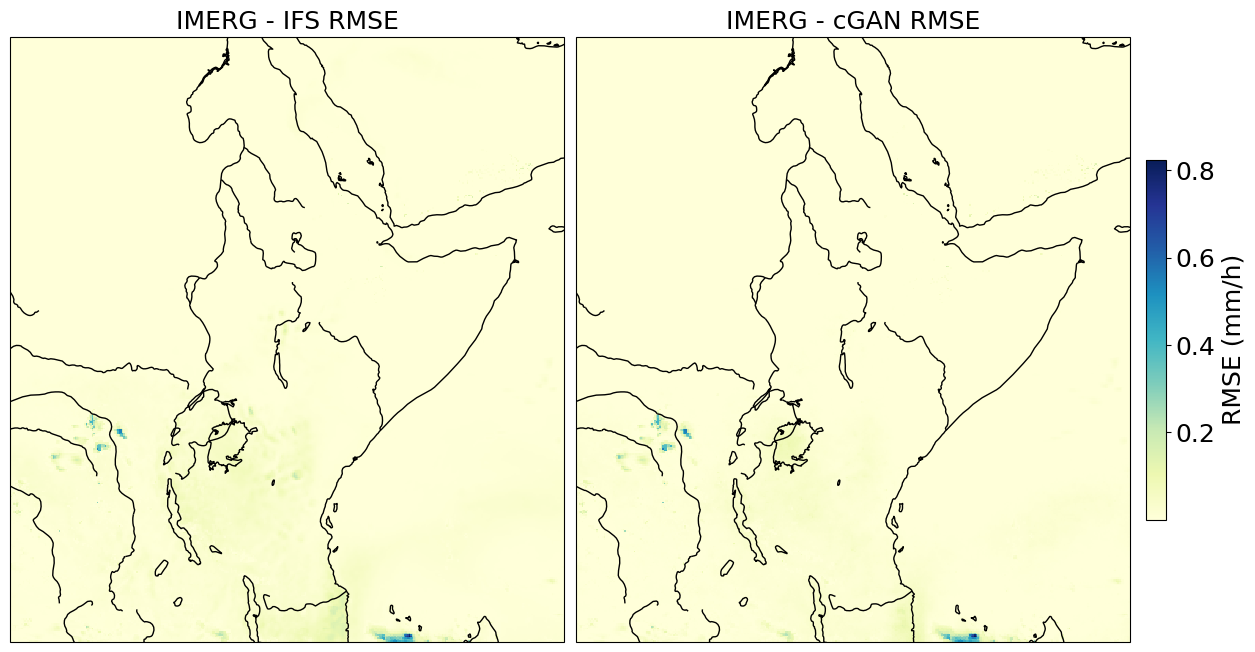

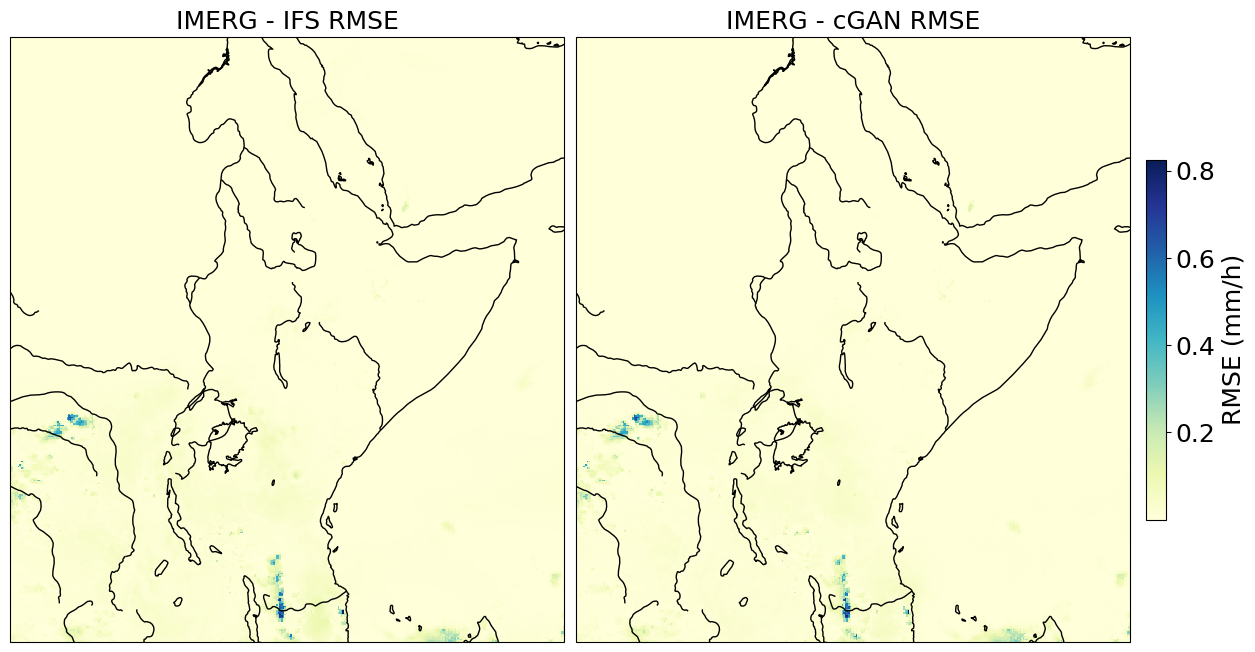

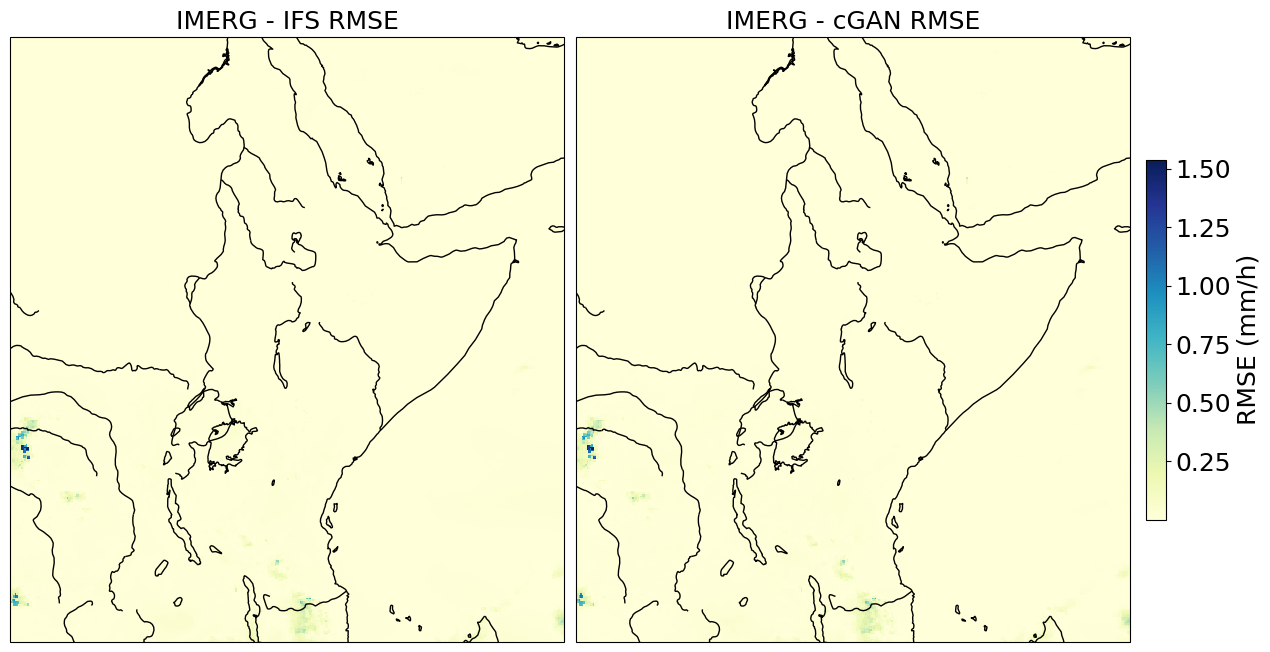

In [193]:
for valid_time_num in range(4):  # There are 4 valid times in each GAN forecast

    # Define the figure and each axis for the rows and columns
    fig, axs = plt.subplots(nrows=1,ncols=2,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16,8))
    
    # axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
    axs=axs.flatten()
    
    # Make the plots
    
    ax=axs[0]
    ax.set_facecolor('white')  # For consistency with Harris et. al 2022
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
    ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
    c = ax.pcolormesh(longitude, latitude, IFS_RMSE[valid_time_num,:,:], 
                      #norm=colors.LogNorm(*value_range_precip),
                      # vmin=0, vmax=10,
                      transform=ccrs.PlateCarree(), cmap='YlGnBu')
    ax.set_title("IMERG - IFS RMSE",size=18)
    
    ax=axs[1]
    ax.set_facecolor('white')  # For consistency with Harris et. al 2022
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
    ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
    c = ax.pcolormesh(longitude, latitude, cGAN_RMSE[valid_time_num,:,:], 
                      #norm=colors.LogNorm(*value_range_precip),
                      # vmin=0, vmax=10,
                      transform=ccrs.PlateCarree(), cmap='YlGnBu')
    ax.set_title("IMERG - cGAN RMSE",size=18)
    
    # Adjust the location of the subplots on the page to make room for the colorbar
    fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                        wspace=0.02, hspace=0.02)
    
    # Add a colorbar axis at the bottom of the graph
    cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])
    
    # Draw the colorbar
    cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
    cb.ax.tick_params(labelsize=18)
    cb.set_label('RMSE (mm/h)',size=18)
    
    # Save the picture
    # plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

In [42]:
# Test that the corresponding IFS dates line up correctly with the IMERG times
d = datetime(year,1,1,0)
dt = timedelta(seconds=60*30)
threeHours = timedelta(seconds=60*60*3)
sixHours = timedelta(seconds=60*60*6)
d_IFS = d

# Test times
# for i in range(70):
while (d.year < year+1):
    
    # The time delta in the IFS valid time since the start of the year
    dt_IFS = d_IFS - datetime(d_IFS.year,1,1)

    # Which day we are on
    day_idx = int(dt_IFS.days + dt_IFS.seconds/(3600*24))

    # How many valid times are left over
    dh_IFS = dt_IFS - timedelta(days=day_idx)
    valid_time_idx = int(dh_IFS.seconds/(3600*6))
    
    # We want to use the 24 hour forecast from the previous day rather than the 0 hour forecast
    if (valid_time_idx==0):
        day_idx -= 1
        valid_time_idx = 4
    
    print(f"IMERG: {d}, IFS valid time: {d_IFS}, day_idx={day_idx}, hour_idx={valid_time_idx}")
    
    d += dt
    if (d > d_IFS):
        d_IFS += sixHours

IMERG: 2019-01-01 00:00:00, IFS valid time: 2019-01-01 00:00:00, day_idx=-1, hour_idx=4
IMERG: 2019-01-01 00:30:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 01:00:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 01:30:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 02:00:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 02:30:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 03:00:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 03:30:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 04:00:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 04:30:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 05:00:00, IFS valid time: 2019-01-01 06:00:00, day_idx=0, hour_idx=1
IMERG: 2019-01-01 05:30:00, IFS valid time

In [ ]:
# Compute 6h averages of IMERG that correspond to IFS forecast valid times
d = datetime(year,1,1,0)
d_final = datetime(year+1,1,1)
dt = timedelta(seconds=60*30)
threeHours = timedelta(seconds=60*60*3)
sixHours = timedelta(seconds=60*60*6)
d_IFS = d
count = 0  # There is an additional number in the file name

# The averaged IMERG data
idx_6h = 0
IMERG_rain_6h = np.empty((0,len(longitude),len(latitude)))
IMERG_rain_6h_n = 0
valid_times_check = []

# XXX To test delete
IMERG_rain = np.empty((1,len(longitude),len(latitude)))
IMERG_rain[:] = np.nan

# Whole year
average_computed = False
while (d <= d_final):
    
    # The time delta in the IFS valid time since the start of the year
    dt_IFS = d_IFS - datetime(year,1,1)

    # Which day we are on
    day_idx = int(dt_IFS.days + dt_IFS.seconds/(3600*24))

    # How many valid times are left over
    dh_IFS = dt_IFS - timedelta(days=day_idx)
    valid_time_idx = int(dh_IFS.seconds/(3600*6))
    
    # We want to use the 24 hour forecast from the previous day rather than the 0 hour forecast
    if (valid_time_idx==0):
        day_idx -= 1
        old_day_idx = day_idx
        valid_time_idx = 4
    
    # For feedback only
    if (old_day_idx != day_idx):
        print(f"IMERG: {d}, IFS valid time: {d_IFS}, day_idx={day_idx}, hour_idx={valid_time_idx}")
        old_day_idx = day_idx
    
    # Load rainfall from IMERG
    file_name = f"{IMERG_data_dir}/3B-HHR.MS.MRG.3IMERG.{year}{d.month:02d}{d.day:02d}-S{d.hour:02d}{d.minute:02d}00-E{d.hour:02d}{d.minute+29:02d}59.{count:04d}.V06B.HDF5.nc4"
    if exists(file_name):
        # Load the data that exists
        nc_file = nc.Dataset(file_name)
        IMERG_rain = np.array(nc_file["precipitationCal"][:,:,1:])
        nc_file.close()
    else:
        # The data doesn't exist
        IMERG_rain = np.empty((len(longitude),len(latitude)))
        IMERG_rain[:] = np.nan
    
    # Average the data
    if (day_idx >= 0):
        # If we are looking at the next time period
        if (idx_6h == IMERG_rain_6h.shape[0]):
            IMERG_rain_6h = np.append(IMERG_rain_6h, np.zeros((1,len(longitude),len(latitude))), axis=0)
        IMERG_rain_6h[idx_6h,:,:] += IMERG_rain[0,:,:]
        IMERG_rain_6h_n += 1
        average_computed = False
    
    # The IFS date is the same as the IMERG date
    if (day_idx >= 0) and (d == d_IFS):
        if (IMERG_rain_6h_n == 0):  # No data
            IMERG_rain_6h[idx_6h,:,:] = np.nan
        else:
            IMERG_rain_6h[idx_6h,:,:] /= IMERG_rain_6h_n
            IMERG_rain_6h_n = 0
        
        # The time average has been computed
        average_computed = True
        
        # Go to the next output time
        idx_6h += 1
        # Save the current valid time
        valid_times_check.append(d)
    
    d += dt
    if (d > d_IFS):
        d_IFS += sixHours
        
    # Increment the count in the file name
    count += 30
    if (count > 1411):
        count = 0
        
# If the final output time was never finished
if (average_computed == False):
    IMERG_rain_6h[idx_6h,:,:] = np.nan

In [149]:
# Load the IFS forecast for a single valid time each day
file_name = f"{IFS_data_dir}/{year}/tp.nc"
nc_file = nc.Dataset(file_name)
tp = np.array(nc_file["tp_mean"][:,1,:,:])*1000/6  # Convert from m/6h to mm/h
nc_file.close()

In [194]:
np.min(tp+0.1)

0.09964489

In [195]:
# Compute the RMSE:
tp_RMSE = np.sqrt(np.mean((IMERG_to_compare - tp)**2, axis=0))
tp_RMSE_log = np.sqrt(np.mean((np.log(IMERG_to_compare+0.1) - np.log(tp+0.1))**2, axis=0))

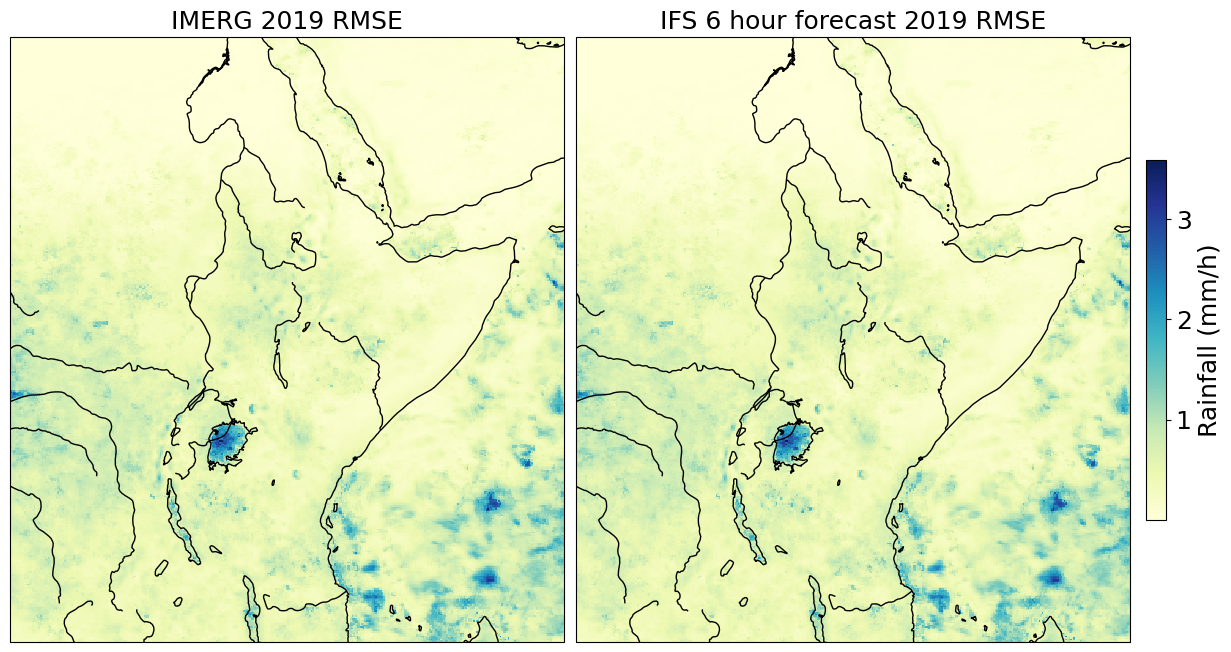

In [191]:
# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, tp_RMSE, 
                  # norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IMERG {year} RMSE",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, tp_RMSE, 
                  # norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IFS 6 hour forecast {year} RMSE",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

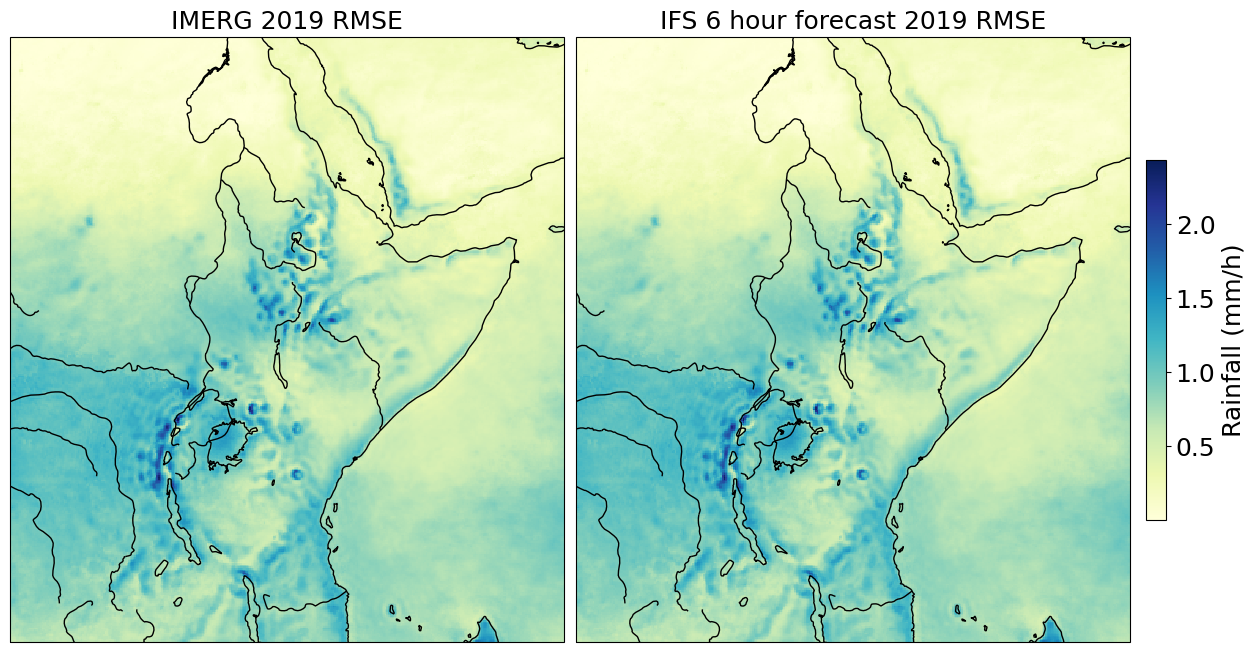

In [196]:
# Define the figure and each axis for the rows and columns
fig, axs = plt.subplots(nrows=1,ncols=2,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16,8))

# axs is a 2 dimensional array of `GeoAxes`. Flatten it into a 1-D array
axs=axs.flatten()

# Make the plots

ax=axs[0]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, tp_RMSE_log, 
                  # norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IMERG {year} RMSE",size=18)

ax=axs[1]
ax.set_facecolor('white')  # For consistency with Harris et. al 2022
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.RIVERS, linewidth=1,edgecolor='black')
ax.add_feature(cfeature.LAKES, linewidth=1,linestyle='-',edgecolor='black',facecolor='none')
c = ax.pcolormesh(longitude, latitude, tp_RMSE_log, 
                  # norm=colors.LogNorm(*value_range_precip),
                  # vmin=0, vmax=10,
                  transform=ccrs.PlateCarree(), cmap='YlGnBu')
ax.set_title(f"IFS 6 hour forecast {year} RMSE",size=18)

# Adjust the location of the subplots on the page to make room for the colorbar
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.1, right=0.8,
                    wspace=0.02, hspace=0.02)

# Add a colorbar axis at the bottom of the graph
cbar_ax = fig.add_axes([0.81, 0.275, 0.0125, 0.45])

# Draw the colorbar
cb=fig.colorbar(c, cax=cbar_ax,orientation='vertical')
cb.ax.tick_params(labelsize=18)
cb.set_label('Rainfall (mm/h)',size=18)

# Save the picture
# plt.savefig(f"{plot_dir}/test.png", format="png", bbox_inches='tight')

In [ ]:
# Plot the RMSE
# RMSE as a function of month
# RMSE of the log of rainfall?

# Need to run cGAN rather than just compute these numbers